# Photoluminescence Statistical Analysis (PLSA) and Parameter Correlations

### Libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy.signal import peak_widths
from scipy.optimize import curve_fit

## Data Corrections

### Laser Correction

This cell calculates a correction ratio (lasratio) that is applied to the PL intensity values to account for variations in laser output each day experimental data were collected. The chosen normalization value is 2e4 for a 1000 ms exposure time, but is arbitrary and can be changed as long as it is kept constant for all experiments. lasratio is calculated with the laser intensity at the spectrometer data point closest to the laser output wavelength. For these experiments the laser signal was collected as it was reflected from a clean glass slide, encapsulated in a lens tube with quartz windows, with a longpass filter at the spectrometer entrance, and after a laser warm-up of at least 10 minutes. Adjust these criteria to fit the experimental set up in a reproducible manner. 

In [2]:
path='C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\2022\\0607_all\\'
las=pd.read_csv(path+'glass_0607_10mW_1000ms1.txt',header=None,sep='\t')

lasval=int(las[las[0]==488.116605394004][1])
lasratio=lasval/2e4
print(lasratio)

2.5678


### Optical Density Correction

This cell corrects for variations in thickness by tracking the optical density at the excitation wavelength (excwav) using UV-vis absorption spectroscopy. The OD correction is normalized "locally" per experiment by setting the control sample's OD value as the normalization constant. A simple background correction is applied to the absorption spectra at the excitation wavelength.

In [3]:
path_UVvis='C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\2022\\0607_all\\UVvis\\'
excwav=488

ODbase=pd.read_csv(path_UVvis+'100Tbaseline.csv')
ODctrl=pd.read_csv(path_UVvis+'C.Sample.Raw.csv')
ODctrl[' A'][ODctrl['nm']==excwav]=float(ODctrl[' A'][ODctrl['nm']==excwav])-float(ODbase[' A'][ODbase['nm']==excwav])
ODval=round(float(ODctrl[ODctrl['nm']==excwav][' A']),3)

ODrat=[]
flist_names=[]
flist=pd.Series([file for file in os.listdir(path_UVvis) if file.endswith('.Sample.Raw.csv')])
for file in flist:
    OD=pd.read_csv(path_UVvis+file)
    OD[' A'][OD['nm']==excwav]=float(OD[' A'][OD['nm']==excwav])-float(ODbase[' A'][ODbase['nm']==excwav])
    ODrat.append(round(float(OD[OD['nm']==excwav][' A']),3)/ODval)
    flist_names.append(str(file).split('.')[0])

UVvis_df=pd.Series(ODrat,index=flist_names)
display(UVvis_df)

C+B     0.524606
C+P     1.023622
C       1.000000
CW      0.785433
NS+P    0.838091
NS      0.937008
P+P     0.898622
P       0.984744
PS+P    0.727854
PS      0.832185
dtype: float64

## Statistical Analysis on PL Data

### Importing and Building PL Data DataFrame

Each sample type's data should be stored in a folder with that sample's name. For example, the folder that contains this project's data has a folder for each of the different sample types ("C", "C+P", "NS", etc.), a folder for the UVvis data ("UVvis"), and a folder for any extra data that is not being processed at this time ("extra"). In each of the sample type folders, there are two types of txt files: those with "plsa" in the filename (data taken for the statistical analysis) and those with "idpl" in the filename (data taken for the intensity-dependent analysis). This analysis only considers the former type.

The final DataFrame contains average PL signal ("\_mean") and the standard error of the PL signal intensity at all wavelengths ("\_se") for each sample type. An additional DataFrame presents the standard error in the peak PL intensity position (in nm).

In [4]:
path='C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\2022\\0607_all\\'
wav=pd.Series(pd.read_csv(path+'C\\C_plsa_10.txt',usecols=[0],sep='\t',header=None)[0])

folderlist=[file for file in os.listdir(path) if (os.path.isfile(path+file)==False and file!='UVvis' and file!='extra')]
print("Sample Types: " + str(folderlist))

flist=pd.DataFrame()
for folname in folderlist:
    filelist=pd.Series([file for file in os.listdir(path+folname) if 'plsa' in file])
    flist[folname]=filelist
    
PLSAdf=pd.DataFrame()
PLSAdf_peakerr=pd.DataFrame(index=folderlist,columns=['PeakPos'])
for f in flist:
    collection_df=pd.DataFrame()  # temporary df to load data from all files in flist
    ODratio=UVvis_df[f]
    for i in range(len(flist[f])):
        x=pd.read_csv(path+f+'\\'+flist[f][i],usecols=[1],sep='\t',header=None)[1]
        collection_df[f+str(i)]=x
    PLSAdf[f+'_mean']=(collection_df.mean(axis=1)/lasratio/ODratio).rolling(20).mean().fillna(method='bfill')  # laser and OD corrections applied here
    PLSAdf[f+'_mean']=PLSAdf[f+'_mean'].sub(PLSAdf[f+'_mean'].min())
    PLSAdf[f+'_se']=collection_df.sem(axis=1)
    PLSAdf_peakerr['PeakPos'][f]=wav[collection_df.idxmax()].sem()
        
display(PLSAdf)
display(PLSAdf_peakerr) # in nm
# PLSAdf.to_csv('FASnI3\\0607_all\\'+'ALL_PLSA_df.csv')

Sample Types: ['C', 'C+P', 'NS', 'NS+P', 'P', 'P+P', 'PS', 'PS+P']


C_mean        C_se    C+P_mean      C+P_se     NS_mean       NS_se  \
0      10.248072  483.220288   54.903891  110.113432  102.330634   58.580016   
1      10.248072  479.210902   54.903891  109.579192  102.330634   62.755997   
2      10.248072  499.502964   54.903891  112.168418  102.330634   68.822383   
3      10.248072  486.286814   54.903891   83.324631  102.330634   76.924002   
4      10.248072  495.965157   54.903891  100.931571  102.330634   79.472799   
...          ...         ...         ...         ...         ...         ...   
1019  226.985162  568.974718  169.947636  135.380505  123.896073  112.234327   
1020  225.319340  554.537898  155.558013  121.811500  111.578160  105.412160   
1021  225.686385  559.388851  146.485198  127.072492  103.555671  102.435155   
1022  218.592764  555.345269  144.016069  121.296255   99.447276  101.201703   
1023  212.463003  554.516434  125.188481  127.564991   79.226364   90.661345   

       NS+P_mean     NS+P_se      P_mean       P_se    P+P_mean      P+P_se  \
0     225.140096   91.166634   29.923367  48.052015  134.312008  162.503896   
1     225.140096  100.213332   29.923367  39.995978  134.312008  165.316336   
2     225.140096   99.351992   29.923367  61.888757  134.312008  149.619155   
3     225.140096   74.538637   29.923367  46.182503  134.312008  133.256115   
4     225.140096   92.703759   29.923367  73.162051  134.312008  160.501769   
...          ...         ...         ...        ...         ...         ...   
1019   51.908671  125.611504  349.527783  92.030476   35.001361  160.596161   
1020   35.854204  129.886697  335.514243  80.000700   22.884255  161.757825   
1021   25.379302  106.753215  323.450379  58.603804   18.099819  175.493009   
1022   20.022779  123.402862  300.891684  84.823467   17.812709  163.020168   
1023    0.000000  122.216353  274.614566  74.832589    0.000000  140.204289   

         PS_mean       PS_se   PS+P_mean     PS+P_se  
0     104.528333   82.938322  271.697032   90.985219  
1     104.528333   65.216138  271.697032   88.676425  
2     104.528333   69.476928  271.697032  115.118929  
3     104.528333   75.180761  271.697032   82.471332  
4     104.528333   56.744454  271.697032   81.707356  
...          ...         ...         ...         ...  
1019   18.233318  132.151119   41.380764  119.538761  
1020   12.287747  124.893392   27.009322  107.137110  
1021   10.773861  101.438978   21.642771  115.173496  
1022   11.961338  129.292608   20.366677  104.537761  
1023    0.000000  126.940867    0.000000  110.088177  

[1024 rows x 16 columns]

PeakPos
C     0.948801
C+P   0.580704
NS    0.502118
NS+P  0.420309
P     1.106427
P+P   0.412594
PS     0.58804
PS+P  1.412991

### Plotting Mean PL and PL Uncertainty

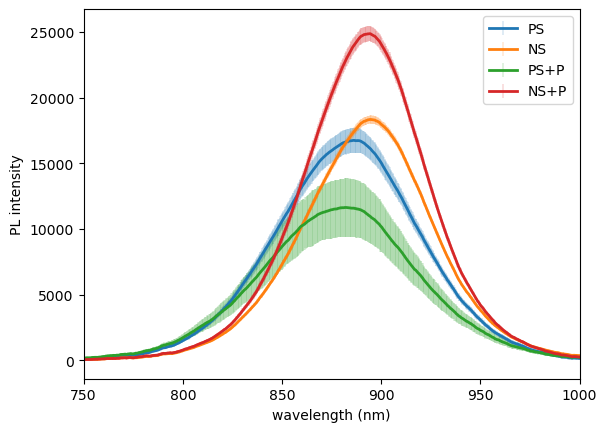

In [5]:
plt.ylabel('PL intensity')
plt.xlabel('wavelength (nm)')
plt.xlim(750,1000)

samplelist=folderlist
samplelist=['PS','NS','PS+P','NS+P']

for p in samplelist:
    plt.errorbar(wav,PLSAdf[p+'_mean'],yerr=PLSAdf[p+'_se'],fmt='-',elinewidth=0.2,lw=2,label=p)
plt.legend()


## Extracting Urbach Energy and Bandgap

### Calculating Urbach Energies

Eu
C     14.36
C+P   14.17
NS     13.6
NS+P  12.93
P     18.39
P+P   13.22
PS    13.01
PS+P  13.89

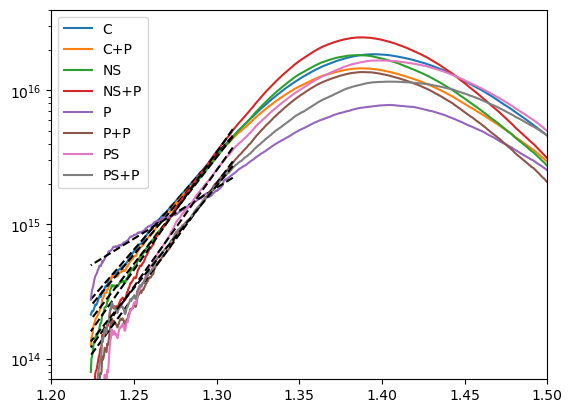

In [6]:
samplelist=folderlist
# samplelist=['C']
Urb=pd.DataFrame(columns=['Eu'],index=folderlist)
PLen=1239.8/wav

# defining van Roosbroeck–Shockley relation
def vRS(x,a,b):
    return b*x*x*np.exp((a-1)*x/0.026)

for j in samplelist:
    PLint=PLSAdf[j+'_mean']*1e12  # 1e12 factor added to help fit converge
    PLen_=[]
    PLint_=[]
    for jj in range(len(PLen)):
        if (PLen[jj] > 1.21 and PLen[jj] < 1.31):
            PLen_.append(PLen[jj])
            PLint_.append(PLint[jj])
    
    plt.semilogy(PLen,PLint,label=j)
    
    prms,cov=curve_fit(f=vRS,
                      xdata=PLen_,
                      ydata=PLint_,
                      p0=[2,2e-4],
                      method='dogbox')
    
    vRSf=[]
    for jj in range(len(PLen_)):
        vRSf.append(vRS(PLen_[jj],prms[0],prms[1]))
    plt.semilogy(PLen_,vRSf,'k--')
    
    Eu=round(0.026/prms[0]*1000,2)
    Urb['Eu'][j]=Eu
    plt.legend()
    
plt.xlim(1.2,1.5)
plt.ylim(0.7e14,4e16)

display(Urb)

### Plotting UV/vis Spectra with PL

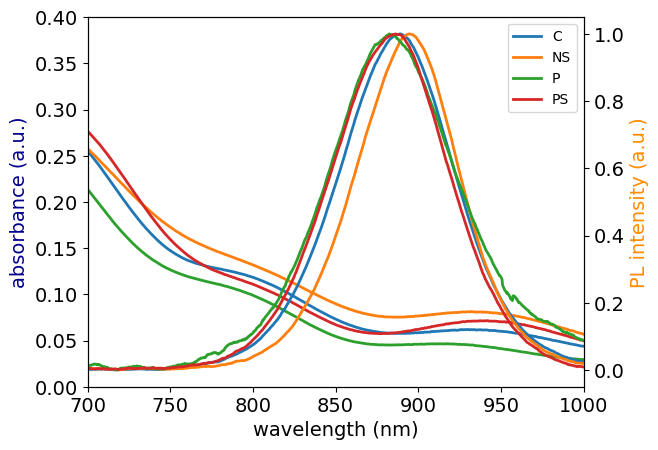

In [7]:
# ODbase=pd.read_csv(path_UVvis+'100Tbaseline.csv')  # loaded in OD correction cell

samplelist=folderlist
samplelist=['C','NS','P','PS']

fig,ax=plt.subplots()
ax.set_xlim(700,1000)
ax.set_ylim(0,0.4)
ax.set_xlabel('wavelength (nm)',fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylabel('absorbance (a.u.)',fontsize=14,c='darkblue')
ax2=ax.twinx()
ax2.set_ylabel('PL intensity (a.u.)',fontsize=14,c='darkorange')
ax2.tick_params(labelsize=14)

for u in samplelist:
    absorb=pd.read_csv(path_UVvis+u+'.Sample.Raw.csv')
    ax.plot(absorb['nm'],absorb[' A'].div(round(float(absorb[absorb['nm']==488][' A']),3)),lw=2,label=u)
    ax2.plot(wav,PLSAdf[u+'_mean']/PLSAdf[u+'_mean'].max(),lw=2)

ax.legend()

### Tauc Plots (Individual)
Batch processing is underway.

In [8]:
print(folderlist)
Egdf=pd.DataFrame(columns=['Eg'],index=folderlist) # ONLY INSTANTIATE ONCE AT THE START OF ONE DATASET!

['C', 'C+P', 'NS', 'NS+P', 'P', 'P+P', 'PS', 'PS+P']


In [9]:
# Sample selection
i=0

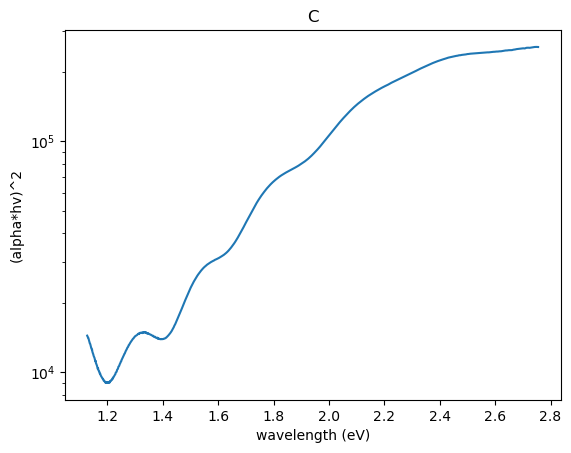

In [10]:
z = 200e-7 # film thickness in cm

UVvis_data = pd.read_csv(path_UVvis+folderlist[i]+'.Sample.Raw.csv') 
wav_UVvis = pd.Series(UVvis_data['nm'], index=UVvis_data.index)
absorp = pd.Series(UVvis_data[' A'], index=UVvis_data.index)
# absorp = absorp.sub(absorp[0]) ## simple baseline substraction
eph = 1239.8/wav_UVvis
alpha = (absorp.mul(2.303)).divide(z); # absorption coefficient calculation

yaxis=[]
yaxis=(alpha.mul(eph)).pow(2)
yaxis=yaxis.iloc[:].rolling(window=20).mean().fillna(method='bfill')
plt.semilogy(eph,alpha)
plt.xlabel('wavelength (eV)')
plt.ylabel('(alpha*hv)^2')
plt.title(folderlist[i]);

Text(0.5, 1.0, 'Derivative of Tauc Plot, C')

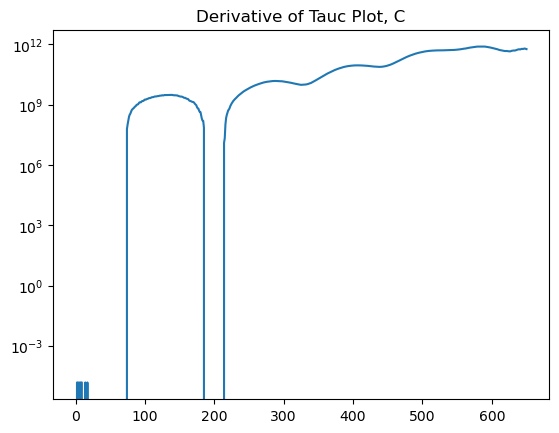

In [11]:
# finding appropriate range of derivative of UVvis spectrum to correctly choose fit range
der=np.gradient(yaxis,eph).tolist()
plt.semilogy(der)
plt.title("Derivative of Tauc Plot, "+str(folderlist[i]))

In [12]:
# Choose limits of finding derivative maximum based on plot output from previous cell. Looking for first maximum after the "0" derivative.
a=225
b=325

der=np.gradient(yaxis,eph).tolist()[a:b]
eph_=eph[a:b].tolist()
dermax=eph_[der.index(max(der))]
# print(dermax)
# plt.semilogy(eph_,der)

C Eg =  1.438 eV


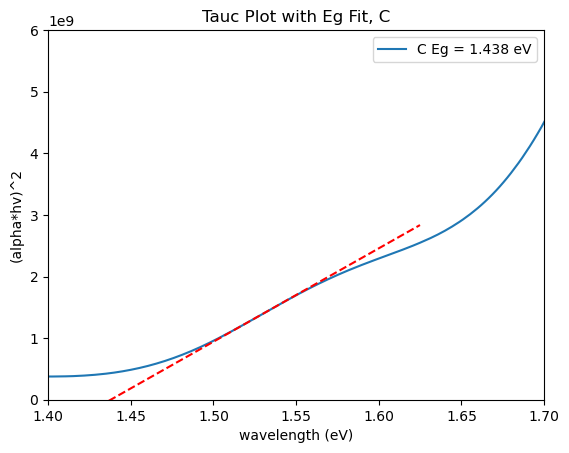

In [13]:
fitmask=[(eph >= dermax-0.01) & ( eph <= dermax+0.02)] # fit range
plotmask=[(eph >= dermax-0.1) & (eph <= dermax+0.1)] # how much of the fit gets plotted

fit,cov = np.polyfit(eph[fitmask[0]],yaxis[fitmask[0]],1,cov=True)

Eg = -fit[1]/fit[0]   # fit[0] = slope, fit[1] = intercept
print(folderlist[i],'Eg = ', round(Eg,3), 'eV')
label = folderlist[i] + " Eg = " + str(format(Eg,'.3f')) + " eV"
plt.plot(eph,yaxis,label=label)
plt.plot(eph[plotmask[0]],fit[1]+fit[0]*eph[plotmask[0]], 'r--')

plt.xlabel('wavelength (eV)')
plt.ylabel('(alpha*hv)^2')
plt.xlim(1.4,1.7)
plt.ylim(0.01,0.6e10)
plt.title("Tauc Plot with Eg Fit, "+str(folderlist[i]))
plt.legend();

In [14]:
# Loading extracted Eg into Eg DataFrame

Egdf["Eg"][folderlist[i]]=Eg
display(Egdf)

Eg
C     1.437834
C+P        NaN
NS         NaN
NS+P       NaN
P          NaN
P+P        NaN
PS         NaN
PS+P       NaN

## Importing Data from Other Analyses

In [15]:
# Intensity-Dependent PL Parameter Analysis
IDPL=pd.DataFrame(pd.read_csv(path+'idpl_analysis.csv',index_col=0))
display(IDPL)

tc_params=pd.DataFrame(pd.read_csv(path+'TCparams.csv',index_col=0))
display(tc_params)

# GIWAXS Parameter Analysis
VolChange=pd.DataFrame(pd.read_csv(path+'lattice_constants.csv',index_col=0))
display(VolChange)

pk_params=pd.DataFrame(pd.read_csv(path+'OOP_pk_params.csv',index_col=0))
display(pk_params)

delpeak    delinfl
C      8.490322  14.477186
C+B   16.576726  26.264582
C+P   14.151501   3.147694
CW    21.074531  19.476256
NS    10.062315   0.629586
NS+P  21.703131  23.252915
P     16.675375  34.133606
P+P    8.805532   4.092333
PS    16.987831  10.623416
PS+P  17.304825  29.753262

TC_high      TC_del      TC_low
C     471.491306   34.423918  437.067388
C+B   553.380287  116.780160  436.600127
C+P   439.962120   44.083336  395.878784
CW    522.435627   90.904699  431.530928
NS    444.958817   35.722715  409.236101
NS+P  473.259779   98.627002  374.632777
P     512.551227   20.588649  491.962578
P+P   462.387672   51.499641  410.888031
PS    483.430423   69.012780  414.417644
PS+P  586.405023  113.637945  472.767078

a         c  vol_change
C     8.80476  12.49660    0.000005
P     8.85654  12.60060    2.021610
NS    8.88221  12.46541    1.513070
PS    8.88221  12.52762    2.019650
C+P   8.85654  12.60060    2.021610
P+P   8.85654  12.66475    2.541030
NS+P  8.85654  12.60060    2.021610
PS+P  8.85654  12.66475    2.541030
C+B   8.83014  12.54964    1.004060
CW    8.88221  12.46541    1.513070

f     f'  pk2_FWHM
C     0.774  0.110       NaN
P     0.846  0.394    69.136
NS    0.733 -0.053       NaN
PS    0.958  0.835    49.953
C+P   0.674 -0.285       NaN
P+P   0.893  0.578    53.337
NS+P  0.669 -0.302       NaN
PS+P  0.923  0.696    54.494
C+B   0.642 -0.411       NaN
CW    0.673 -0.286       NaN

## Generating Master Parameter DF

Each column in the master DataFrame ("SUMdf") represents an extracted physical parameter (e.g. "TC_del" = the change in carrier temeprature extracted from intensity-depenedent PL data; "VolChange" = change in the volume of the unit cell extracted from GIWAXS data; and "pk1_OOP_H" = the calculated Herman Orientation Parameter for the first scattering peak in the GIWAXS data). These parameters also include those extracted in the above cells from the PL statistcial analysis and the UVvis absorption spectra. However, the parameters chosen for comparison can be changed to tailor to a different set of experiments.

In [16]:
samplelist=folderlist
# samplelist = ['C','P','NS','PS']

SUMdf=pd.DataFrame(index=samplelist,columns=['PeakIntensity','PeakPos','PeakPos_SE','FWHM','SE',
                                             'Urb','IDPL_delPeak','IDPL_delInfl','TC_low','TC_high','TC_del'])
                                             # 'Eg_dev','VolChange',
                                             # 'pk1_OOP_H','pk2_FWHM'])
        
for p in samplelist:
    SUMdf['PeakIntensity'][p]=PLSAdf[p+'_mean'].max()
    SUMdf['PeakPos'][p]=wav[PLSAdf[p+'_mean'].idxmax()]
    SUMdf['PeakPos_SE']=PLSAdf_peakerr['PeakPos']
    SUMdf['FWHM'][p]=wav[round(peak_widths(PLSAdf[p+'_mean'],peaks=[PLSAdf[p+'_mean'].idxmax()])[0][0])]-wav[0]
    SUMdf['SE'][p]=PLSAdf[p+'_se'][PLSAdf[p+'_mean'].idxmax()]*2/PLSAdf[p+'_mean'].max()   # normalized to intensity
    SUMdf['Urb'][p]=Urb['Eu'][p]
    SUMdf['IDPL_delPeak'][p]=IDPL['delpeak'][p]
    SUMdf['IDPL_delInfl'][p]=IDPL['delinfl'][p]
    SUMdf['TC_low'][p]=tc_params['TC_low'][p]
    SUMdf['TC_high'][p]=tc_params['TC_high'][p]
    SUMdf['TC_del'][p]=tc_params['TC_del'][p]
    # SUMdf['Eg_dev']=abs(Egdf.sub(1238.9/SUMdf['PeakPos'])*1000)
    # SUMdf['VolChange'][p]=VolChange['vol_change'][p]
    # SUMdf['pk1_OOP_H'][p]=pk_params['f'][p]
    # SUMdf['pk2_FWHM'][p]=pk_params['pk2_FWHM'][p]

display(SUMdf)


PeakIntensity     PeakPos PeakPos_SE       FWHM        SE    Urb  \
C     18603.932355  889.073563   0.948801  79.918249  0.415969  14.36   
C+P   14609.252495  893.161262   0.580704  79.292082  0.210276  14.17   
NS    18338.661566  894.418893   0.502118  72.403539  0.034018   13.6   
NS+P  24868.684243  894.104491   0.420309  68.645604  0.047615  12.93   
P      7787.832558  882.469075   1.106427  86.179307  0.161461  18.39   
P+P   13715.531351  892.218001   0.412594  71.150937  0.132415  13.22   
PS    16751.172518  886.243261    0.58804  82.735861  0.112715  13.01   
PS+P  11633.864133  881.839995   1.412991  88.057409  0.382049  13.89   

     IDPL_delPeak IDPL_delInfl      TC_low     TC_high      TC_del  
C        8.490322    14.477186  437.067388  471.491306   34.423918  
C+P     14.151501     3.147694  395.878784   439.96212   44.083336  
NS      10.062315     0.629586  409.236101  444.958817   35.722715  
NS+P    21.703131    23.252915  374.632777  473.259779   98.627002  
P       16.675375    34.133606  491.962578  512.551227   20.588649  
P+P      8.805532     4.092333  410.888031  462.387672   51.499641  
PS      16.987831    10.623416  414.417644  483.430423    69.01278  
PS+P    17.304825    29.753262  472.767078  586.405023  113.637945

### FWHM, Peak Position, Standard Error at Peak Data Summary

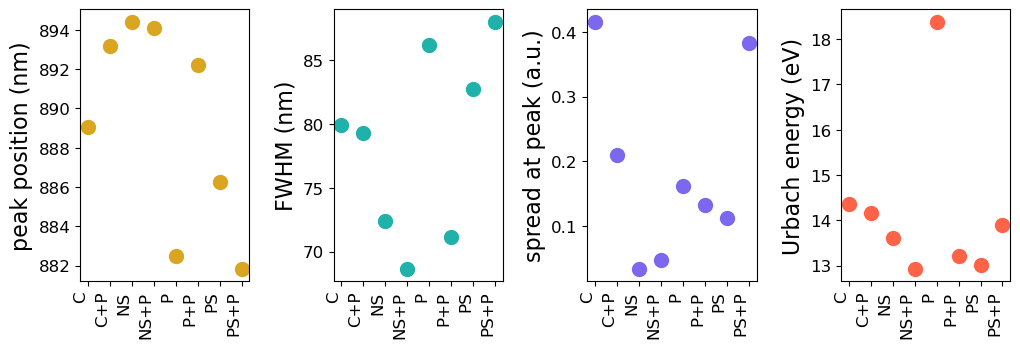

In [17]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=4,sharex=True,figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, 
                    wspace=0.5)

ax1.plot(SUMdf['PeakPos'].dropna(),'o',ms=10,c='goldenrod')
ax1.set_ylabel('peak position (nm)',fontsize=16)
ax1.tick_params(labelsize=12)

ax2.plot(SUMdf['FWHM'].dropna(),'o',c='lightseagreen',ms=10)
ax2.set_ylabel('FWHM (nm)',fontsize=16)
ax2.tick_params(labelsize=12)

ax3.plot(SUMdf['SE'].dropna(),'o',c='mediumslateblue',ms=10)
ax3.set_ylabel('spread at peak (a.u.)',fontsize=16)
ax3.tick_params(labelsize=12)

ax4.plot(SUMdf['Urb'].dropna(),'o',c='tomato',ms=10)
ax4.set_ylabel('Urbach energy (eV)',fontsize=16)
ax4.tick_params(labelsize=12)

fig.autofmt_xdate(rotation=90)

# fig.savefig('FASnI3\\0502_PEASCN\\'+'HS_all_peaks.png',dpi=500,bbox_inches='tight')

## Linear Correlations

PeakIntensity   PeakPos  PeakPos_SE      FWHM        SE  \
PeakIntensity       1.000000  0.694373   -0.600093 -0.713502 -0.311855   
PeakPos             0.694373  1.000000   -0.865694 -0.909144 -0.511793   
PeakPos_SE         -0.600093 -0.865694    1.000000  0.856389  0.751177   
FWHM               -0.713502 -0.909144    0.856389  1.000000  0.614511   
SE                 -0.311855 -0.511793    0.751177  0.614511  1.000000   
Urb                -0.688515 -0.547070    0.529455  0.536861  0.157295   
IDPL_delPeak        0.132728 -0.282456    0.141840  0.181240 -0.229207   
IDPL_delInfl       -0.316718 -0.739887    0.724031  0.540917  0.310687   
TC_low             -0.808236 -0.890766    0.887661  0.818517  0.525021   
TC_high            -0.466762 -0.851049    0.856359  0.697321  0.510721   
TC_del              0.299959 -0.151689    0.163018  0.018036  0.102457   

                    Urb  IDPL_delPeak  IDPL_delInfl    TC_low   TC_high  \
PeakIntensity -0.688515      0.132728     -0.316718 -0.808236 -0.466762   
PeakPos       -0.547070     -0.282456     -0.739887 -0.890766 -0.851049   
PeakPos_SE     0.529455      0.141840      0.724031  0.887661  0.856359   
FWHM           0.536861      0.181240      0.540917  0.818517  0.697321   
SE             0.157295     -0.229207      0.310687  0.525021  0.510721   
Urb            1.000000      0.057894      0.568040  0.753648  0.250062   
IDPL_delPeak   0.057894      1.000000      0.623335 -0.015231  0.419566   
IDPL_delInfl   0.568040      0.623335      1.000000  0.664958  0.784984   
TC_low         0.753648     -0.015231      0.664958  1.000000  0.724776   
TC_high        0.250062      0.419566      0.784984  0.724776  1.000000   
TC_del        -0.544997      0.619358      0.327673 -0.160138  0.564029   

                 TC_del  
PeakIntensity  0.299959  
PeakPos       -0.151689  
PeakPos_SE     0.163018  
FWHM           0.018036  
SE             0.102457  
Urb           -0.544997  
IDPL_delPeak   0.619358  
IDPL_delInfl   0.327673  
TC_low        -0.160138  
TC_high        0.564029  
TC_del         1.000000

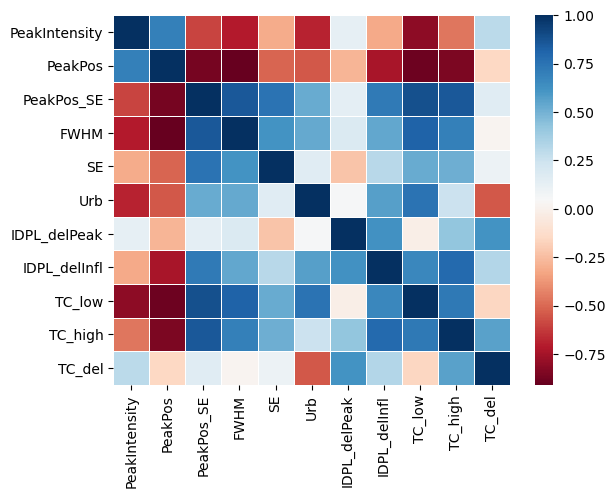

In [18]:
display(SUMdf.astype('float64').corr(method='pearson'))

sns.heatmap(SUMdf.astype('float64').corr(),cmap='RdBu',linecolor='white',linewidth=0.5);
plt.show()
# sns.pairplot(SUMdf)

## Parameter Averages in Material Groups

The sample types are categorized by additive type and by incorporation method. For example, "PEA" and "2(PEA)" correspond to one and two 'doses' of phenethylammonium additives; and "PEA(a)" and "PEA(c)" correspond to the phenethylammonium additive incorporated before and after film processing respectively. A dictionary defines which samples fall into each of the categories. Then, for each category the values of the parameters for the samples in that category are numerically averaged. The "AVGdf" DataFrame records the average values.

PeakIntensity     PeakPos       FWHM        SE      Urb     TC_high  \
Control  18603.932355  889.073563  79.918249  0.415969    14.36  471.491306   
SCN(a)   17544.917042  890.331077    77.5697  0.073366   13.305   464.19462   
PEA(a)   12269.502538  884.356168  84.457584  0.137088     15.7  497.990825   
PEA       13049.41919  887.291199   82.73575  0.161484    15.19  478.647923   
2(PEA)   12674.697742  887.028998  79.604173  0.257232   13.555  524.396348   
PEA(c)   16206.833056  890.330937  76.786508  0.193089  13.5525  490.503649   

            TC_del  
Control  34.423918  
SCN(a)   52.367747  
PEA(a)   44.800714  
PEA      44.561588  
2(PEA)   82.568793  
PEA(c)   76.961981

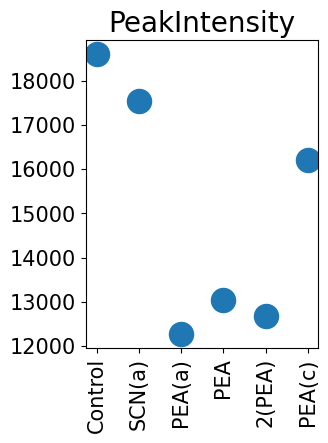

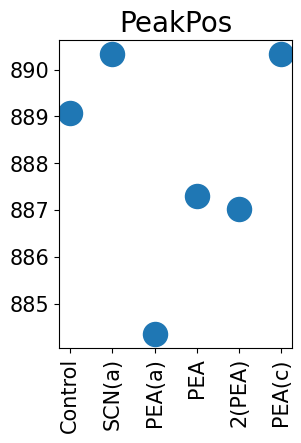

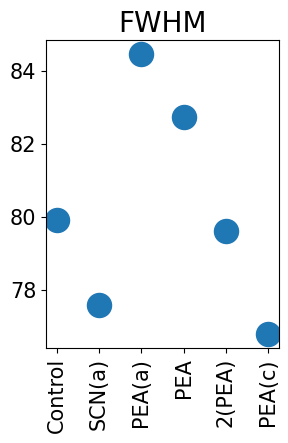

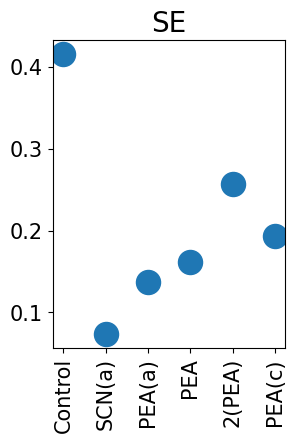

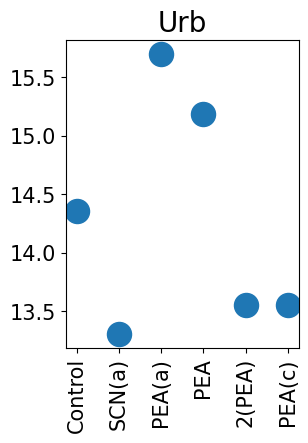

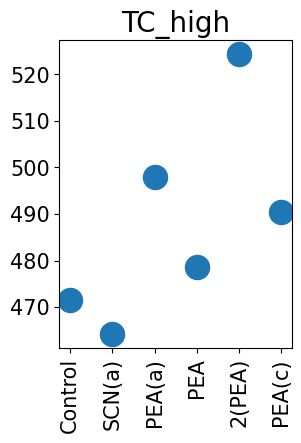

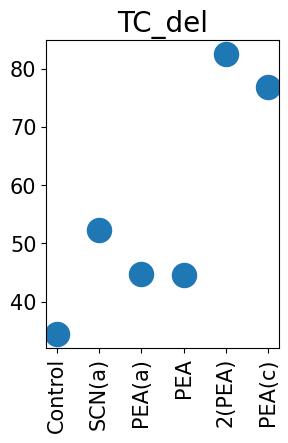

In [19]:
index=['Control','PEA','2(PEA)','SCN(a)','PEA(a)','PEA(c)'] # categories for averaging
adict={}
index=adict.keys()

adict['Control']=['C']
adict['SCN(a)']=['NS','PS']
adict['PEA(a)']=['P','PS']
adict['PEA']=['P','PS','C+P']
adict['2(PEA)']=['P+P','PS+P']
adict['PEA(c)']=['C+P','P+P','PS+P','NS+P']

AVGdf=pd.DataFrame(index=index,columns=['PeakIntensity','PeakPos','FWHM','SE',
                                             'Urb','TC_high','TC_del'])

for y in AVGdf:
    for x in index:
        list=[]
        for xx in adict[x]:
            list.append(SUMdf[y][xx])
        AVGdf[y][x]=sum(list)/len(list)
display(AVGdf)

for y in AVGdf:
    plt.figure(figsize=(3,4))
    plt.scatter(index,AVGdf[y],s=300)
    plt.tick_params(labelsize=15)
    plt.title(y,fontsize=20)
    plt.xticks(rotation=90)
    plt.show()

# plt.savefig(path+'avgparam_HOP_IM.png',dpi=400,bbox_inches='tight')
plt.show()